# MicroJax

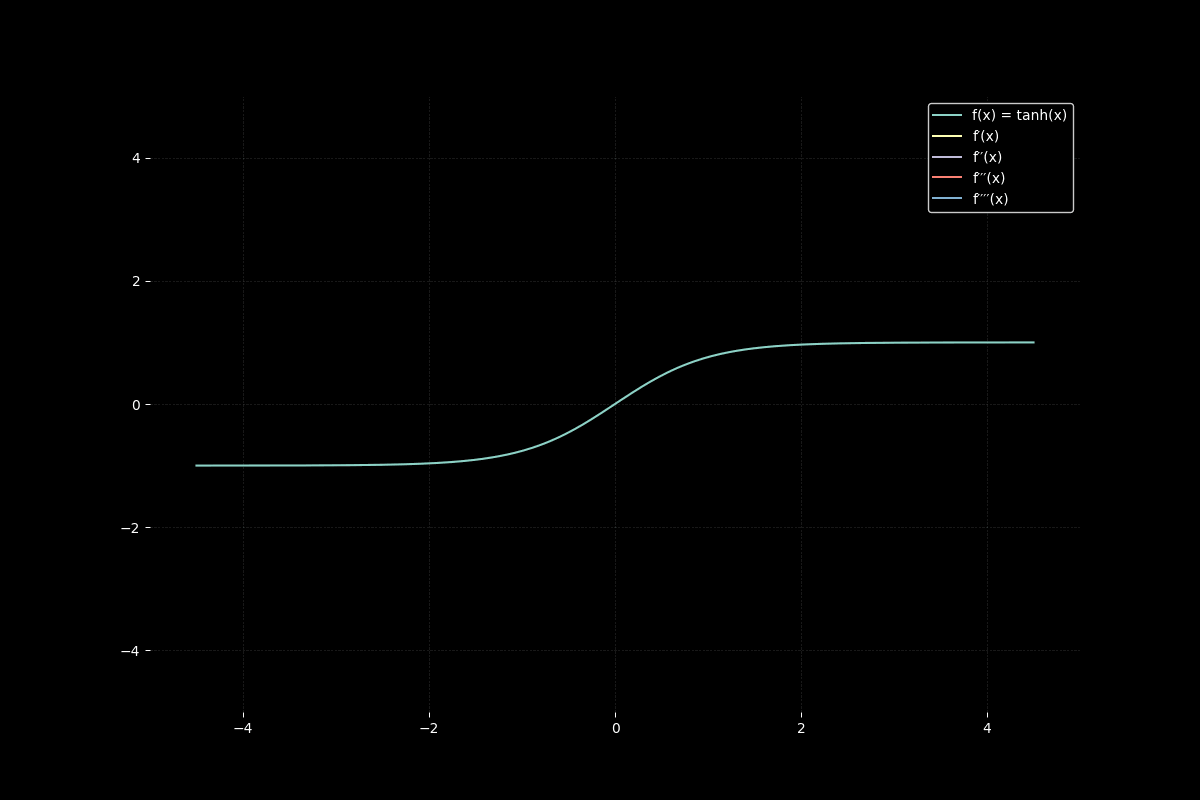

This is a micro dev blog on how to build a micro Jax / mlx-like transformation engine,
because I don't find anything easy that explains function transformation engines on the internet. Just like Karpathy-senpai's micrograd is a simple version of PyTorch, microjax is a simpler version of Jax.
 
Warning: This is made for understanding with incrementally increasing complexity, not absolute correctness.
 
Way back, Google was TensorFlow-pilled. Google has a custom chip TPU and XLA, a really smart linear algebra compiler to make it go brr, but TensorFlow was awful to work with. Other growing frameworks like PyTorch had a dynamic nature that wasn't that great. Jax was an experimental project from Google that converts Python traces to XLA, which can be compiled with MLIR and run on accelerators like GPUs and TPUs. We can divide Jax into two parts: function transformation and XLA compiler. Function transformation gives us the ability to calculate gradients, Hessians, and define vmap-like transformations, while XLA IR conversion gives us speed. Here we will only cover a simple function transformation engine, so the X part of Jax is not here, but hey, MLX has X so I don't care, I'm calling it microjax. Although Jax has gone more mainstream recently, the story of Jax goes back to autograd.
 
Autograd had a more novel goal. You need to calculate gradients for machine learning or scientific computing, and Python is the language of scientific computing. So let's make Python differentiable, but how can one make a high-level, interpreted language like Python differentiable?
 
By writing an interpreter, of course!

## Base Interpretor
first we will start primitive, this are fundameation ops in jax land all all other oprator will be base on it, btw this is scalr valued only so its more easy to understand, (np array are techincally supported but i will not define array ops for simplicity)

In [160]:
from __future__ import annotations

import math
from contextlib import contextmanager
from typing import Any, Callable

In [127]:
class OPS:
    ADD = "add"
    MUL = "mul"
    NEG = "neg"
    RECIP = "recip"
    EXP = "exp"
    SIN = "sin"
# ik i can make this enum, i choose not too :P
print(OPS.ADD)

add


You only need this ops for most this, you can define your own if that tickles your fancy

Lets start with base interpretor, this is like abstract class,

In [128]:
class Interpreter:
    def __init__(self, level: int = 0, *args, **kwargs):
        self.level = level

    def process_primitive(self, prim, boxes, params):
        "in this function, either you process primitives or you unbox and send to lower level interpreter"
        raise NotImplementedError

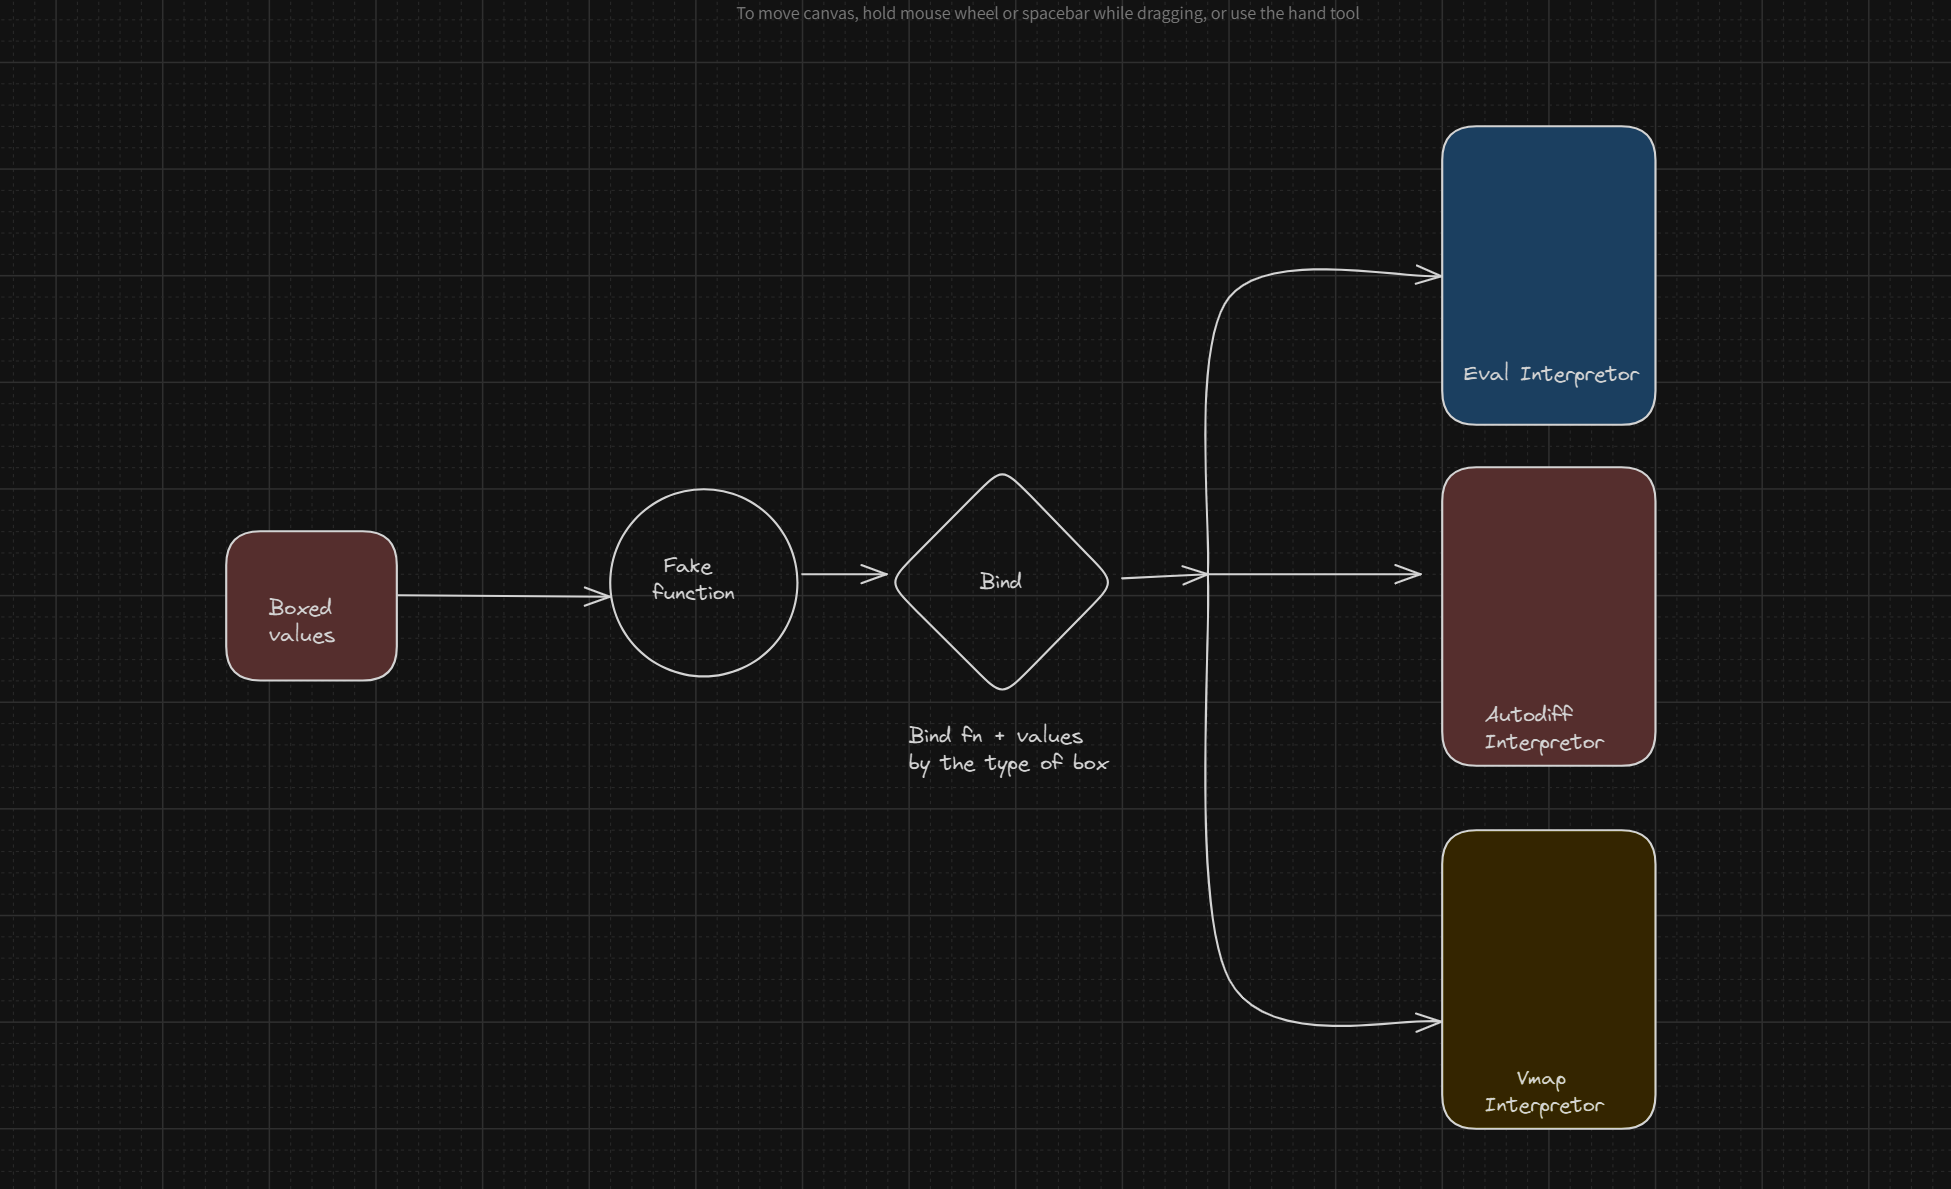

In JAX, this is called a Trace. A Trace keeps track of tracers, which are simply boxed values. We put values in boxes along with some extra information like whether we need to calculate gradients or other things like shape and which interpreter to use.
For each unique type of transformation, we will have a box of that type and an interpreter of that type.

Now we will have multiple interpreters. To know in which context the boxed values should evaluate, we need to keep track of interpreters.
We will do that with the most common data structure: stack.

In [129]:
STACK: list[Interpreter] = []


def push_interpreter(interpreter: Interpreter):
    STACK.append(interpreter)
    return STACK


def pop_interpreter() -> Interpreter:
    return STACK.pop()


@contextmanager
def interpreter_context(interpreter_type: Interpreter):
    stack_item = interpreter_type(level=len(STACK))
    push_interpreter(stack_item)
    try:
        yield stack_item
    finally:
        pop_interpreter()

Now let's define Box,
Box (tracer) is what actually flows through functions you define.
We need to override some dunder methods to make it work with Python.

In [130]:
class Box:
    _interpreter: Interpreter

    def aval(self):
        raise NotImplementedError

    def full_lower(self):
        return self

    def __add__(self, other):
        return add(self, other)

    def __radd__(self, other):
        return add(other, self)

    def __mul__(self, other):
        return mul(self, other)

    def __rmul__(self, other):
        return mul(other, self)

    def __neg__(self):
        return neg(self)

    def __sub__(self, other):
        return add(self, neg(other))

    def __rsub__(self, other):
        return add(other, neg(self))

    def __truediv__(self, other):
        return mul(self, recip(other))

    def __rtruediv__(self, other):
        return mul(other, recip(self))

    def __iadd__(self, other):
        return add(self, other)

    def __imul__(self, other):
        return mul(self, other)

    def __isub__(self, other):
        return add(self, neg(other))

    def __itruediv__(self, other):
        return mul(self, recip(other))

# dont worry about this undefined functions, we add them later

we are almost done with abstract classes 
just few helper

In [131]:
def find_top_interpreter(args):
    """
    find the top level interpreter for the given arguments
    """
    interpreters = []
    for item in args:
        if isinstance(item, Box):
            interpreters.append(item._interpreter)

    if interpreters:
        return max(interpreters, key=lambda x: x.level)

    # if no interpreters are found, return the default EvalInterpreter
    return STACK[0]


def full_raise(interpreter: Interpreter | Any, out) -> Box | JVPBox:
    """
    if interpreter need values boxed
    if out is not boxed, box it (using interpreter.pure)
    ie. raise out to the box level
    """
    if not isinstance(out, Box):
        return interpreter.pure(out)
    return out


def full_lower(val):
    if isinstance(val, Box):
        return val.full_lower()
    return val


def bind(prim, *args, **params):
    interpreter = find_top_interpreter(args)
    
    # this will raise the boxes to the top level
    # eg converts primitive values to Boxes if interpreter is not the top level
    boxes = [full_raise(interpreter, arg) for arg in args]
    
    outs = interpreter.process_primitive(prim, boxes, params)
    
    return [out for out in outs]


def bind_single(prim, *args, **params):
    (out,) = bind(prim, *args, **params)
    return out

Each boxed value will have an interpreter assigned to it. Each interpreter will have a level indicating its position in the stack. The `find_top_interpreter` function will find the highest level interpreter among them all.
`full_raise` will raise up a value to the current interpreter level in the stack. `bind_single` is just a small wrapper to handle the tuple returned by `bind`.

`bind` is importent function, which will call interpreters

### Primitives
These are building blocks, all other functions will build on top of these. I like to call them mock functions as they don't really compute anything; they are more like routers for boxes to interpreters.

In [132]:
def add(*args):
    return bind_single(OPS.ADD, *args)

def mul(*args):
    return bind_single(OPS.MUL, *args)

def neg(x):
    return bind_single(OPS.NEG, x)

def recip(x):
    return bind_single(OPS.RECIP, x)

def exp(x):
    return bind_single(OPS.EXP, x)

def sin(x):
    return bind_single(OPS.SIN, x)


Primitives are like mock functions. When you call `mul(Box1(3), Box1(2))`, this will find interpreters for `Box1(3)` and `Box1(2)`, then find the interpreter
with the highest level among them. It will unbox these values and tell that interpreter to process those primitives.
For every op type, there is a primitive op function.

Composite functions build on top of primitives.
As long as you can express your function in terms of primitives, you can use arbitrarily complicated functions.

In [133]:
def cos(x):
    return sin(x + math.pi / 2)

def sigmoid(x):
    return 1 / (1 + exp(-x))

def tanh(x): 
    return 2 * sigmoid(2 * x) - 1

def silu(x):
    return x * sigmoid(x)

# ### Eval Interpreter

Even if we have nice abstraction layers, at the end someone has to run `add` or `mul` functions. This will be done by the eval interpreter. We will first define evaluation rules and then the eval interpreter.

In [134]:
class EvalRules:
    def __init__(self):
        self.rules = {
            OPS.ADD: self.add,
            OPS.MUL: self.mul,
            OPS.NEG: self.neg,
            OPS.RECIP: self.recip,
            OPS.EXP: self.exp,
            OPS.SIN: self.sin,
        }

    def __getitem__(self, op):
        return self.rules[op]

    def add(self, primals, *args):
        x, y = primals
        return [x + y]

    def mul(self, primals, *args):
        x, y = primals
        return [x * y]

    def neg(self, primals, *args):
        (x,) = primals
        return [-x]

    def recip(self, primals, *args):
        (x,) = primals
        return [1 / x]

    def exp(self, primals, *args):
        (x,) = primals
        return [math.exp(x)]

    def sin(self, primals, *args):
        (x,) = primals
        return [math.sin(x)]


We dont expect any boxed values to be passed to eval interpreter, so we can just call function directly on values, so its straight forward take args and return result

In [135]:
class EvalInterpreter(Interpreter):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rules = EvalRules()

    def pure(self, val):
        return val

    def process_primitive(self, prim, values, params):
        return self.rules[prim](values, *params)

Basic interpreter is `EvalInterpreter`, Now we run run basic program, since evalution are end of primitive we will push eval interpreter at bottom of stack,

In [136]:
push_interpreter(EvalInterpreter())

Now we can kick off basic program,

In [137]:
def func(x):
    return sin(x)*exp(x) + tanh(x)

x = 3.14

func(x)

1.033056645880499

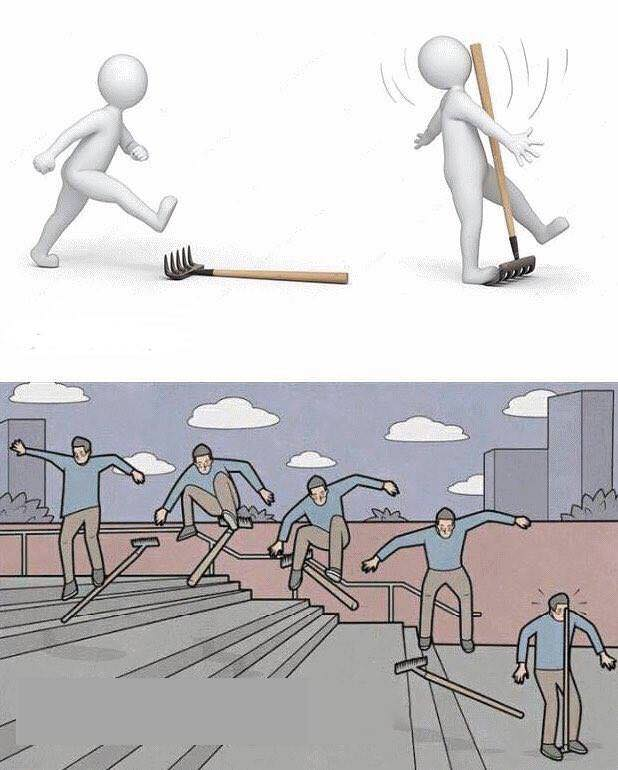

you may feel like this ^ but this abstractions will be used to build more complex AD    

## Automatic diff

### Forward mode Autodiff (JVP)

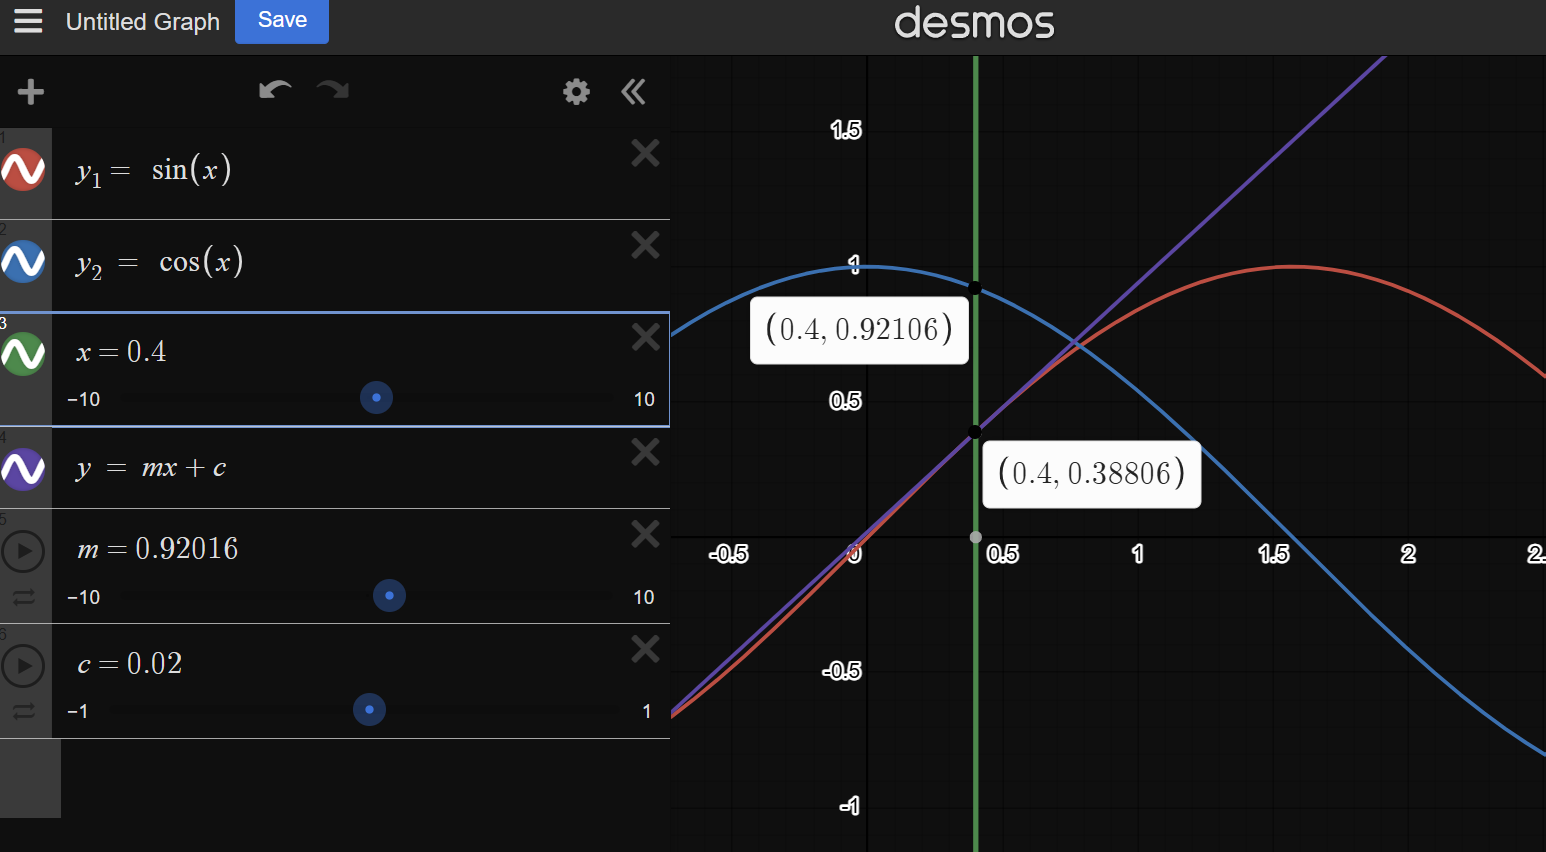

In [138]:
class JVPBox(Box):
    def __init__(self, interpretor: Interpreter, primal, tangent) -> None:
        super().__init__()
        self._interpreter = interpretor
        self.primal = primal
        self.tangent = tangent
    
    def __repr__(self):
        return f"JVPBox (primal={self.primal}, tangent={self.tangent})"


In [139]:
class JVPRules:
    def __init__(self):
        self.rules = {
            OPS.ADD: self.add,
            OPS.MUL: self.mul,
            OPS.NEG: self.neg,
            OPS.RECIP: self.recip,
            OPS.EXP: self.exp,
            OPS.SIN: self.sin,
        }

    # dont forget to return tuple(primals),tuple(tangents)
    def __getitem__(self, op):
        return self.rules[op]

    @staticmethod
    def add(primals, tangents):
        (x, y), (x_dot, y_dot) = primals, tangents
        return (x + y,), (x_dot + y_dot,)

    @staticmethod
    def mul(primals, tangents):
        (x, y), (x_dot, y_dot) = primals, tangents
        return (x * y,), (x_dot * y + x * y_dot,)

    @staticmethod
    def neg(primals, tangents):
        (x,), (x_dot,) = primals, tangents
        return (-x,), (-x_dot,)

    @staticmethod
    def recip(primals, tangents):
        (x,), (x_dot,) = primals, tangents
        y = 1 / x
        return (y,), (-y * y * x_dot,)

    @staticmethod
    def exp(primals, tangents):
        (x,), (x_dot,) = primals, tangents
        y = exp(x)
        return (y,), (y * x_dot,)

    @staticmethod
    def sin(primals, tangents):
        (x,), (x_dot,) = primals, tangents
        return (sin(x),), (cos(x) * x_dot,)


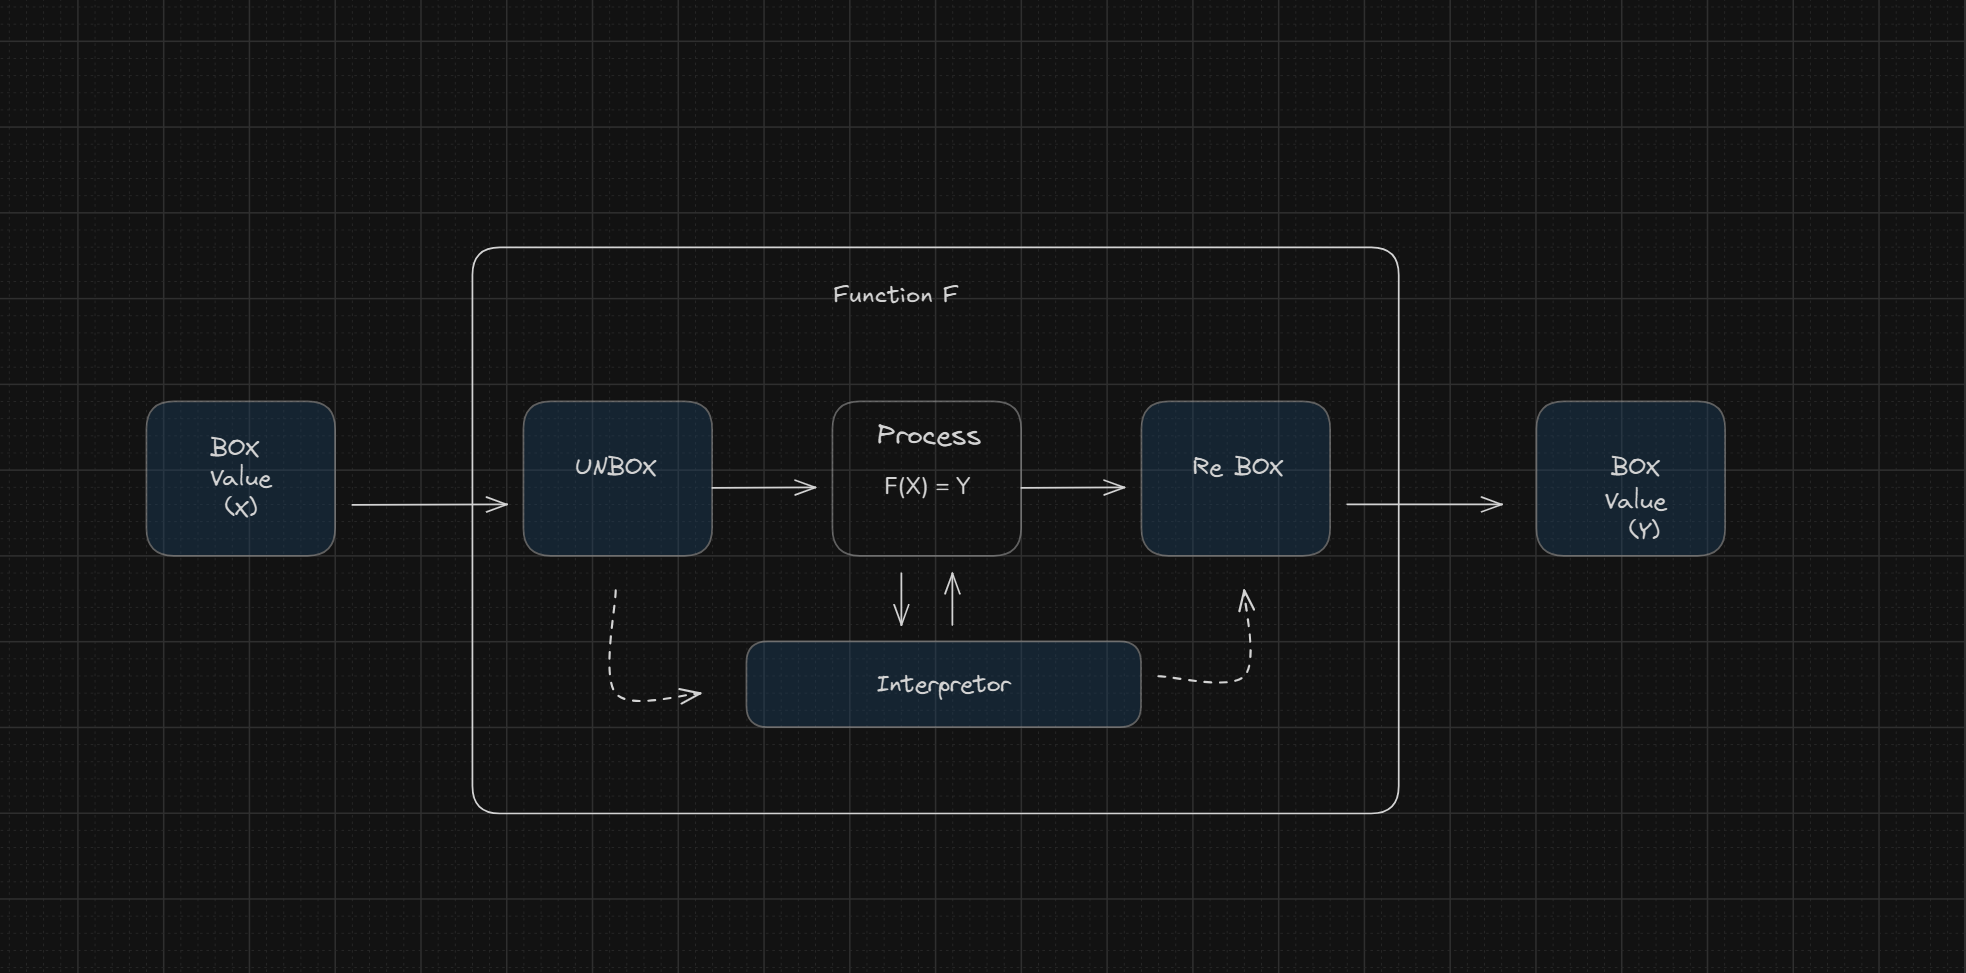

In [140]:
class JVPInterpreter(Interpreter):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rules = JVPRules()

    def pure(self, val):
        return JVPBox(self, val, 0.0)

    def process_primitive(self, prim, boxes, params):
        # unbox values
        primals = [box.primal for box in boxes]
        tangents = [box.tangent for box in boxes]
        
        # process primitive
        op = self.rules[prim]
        primals_out, tangents_out = op(primals, tangents, **params)

        # box values
        result = []
        for p, t in zip(primals_out, tangents_out):
            result.append(JVPBox(self, p, t))
            
        return result


In [141]:
def jvp_simple(func, primals, tangents):
    with interpreter_context(JVPInterpreter) as iptr:
        box_in = [JVPBox(iptr, x, t) for x, t in zip(primals, tangents)]
        out = func(*box_in)
        box_out = full_raise(iptr, out)
        primal_out, tangent_out = box_out.primal, box_out.tangent
    return primal_out, tangent_out

In [142]:

def deriv(function):
    def jvp_forward(input_value):
        _, gradient = jvp_simple(function, (input_value,), (1,))
        return gradient

    return jvp_forward



In [143]:
def func(x):
    return sin(x) 
x = 3.14

print(func(x))

print(deriv(func)(x))
print(deriv(deriv(func))(x))

0.0015926529164868282
-0.9999987317275395
-0.0015926529164865067


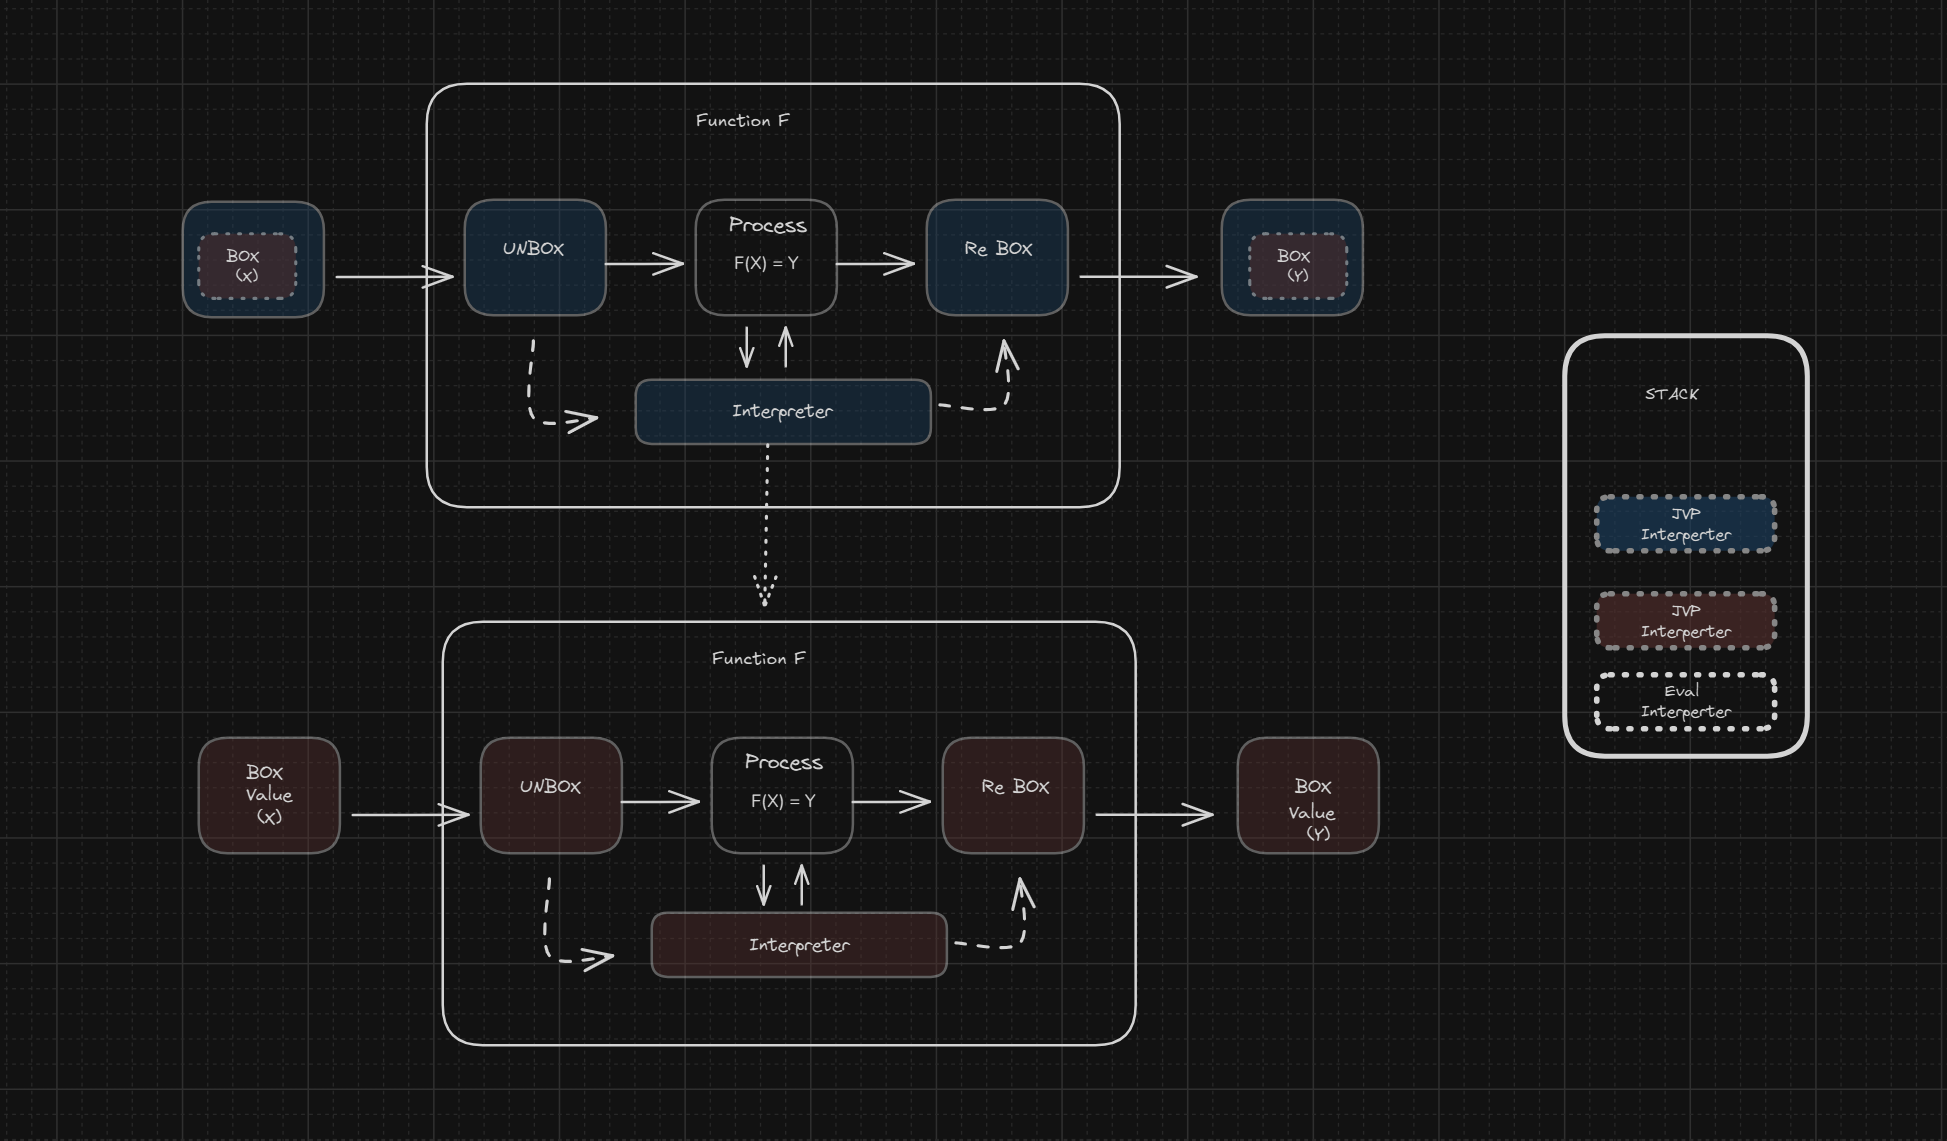

Thats means we can compose derv arbaritary many times, for example
lets take function

$$

f(x) = x \cdot sin(x)
$$

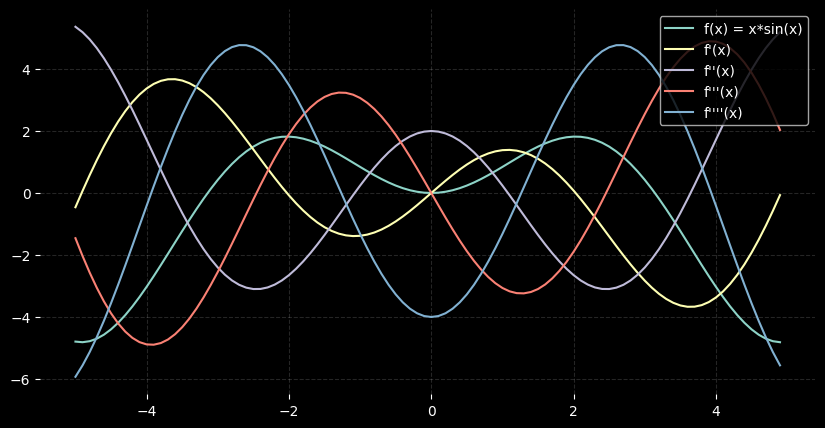

In [144]:
import matplotlib.pyplot as plt
import random
plt.style.use("dark_background")

plt.figure(figsize=(10,5))

def forward(func, vec):
    return [func(x) for x in vec]


x = [i / 10 for i in range(-50, 50)]

def func(x):
    return x*sin(x)

primals = forward(func, x)

# first derivative
f_prime = forward(deriv(func), x)
f_prime2 = forward(deriv(deriv(func)), x)
f_prime3 = forward(deriv(deriv(deriv(func))), x)
f_prime4 = forward(deriv(deriv(deriv(deriv(func)))), x)

plt.plot(x, primals, label='f(x) = x*sin(x)')
plt.plot(x, f_prime, label="f'(x)")
plt.plot(x, f_prime2, label="f''(x)")
plt.plot(x, f_prime3, label="f'''(x)")
plt.plot(x, f_prime4, label="f''''(x)")

plt.grid(True, linestyle="--", alpha=0.15)
plt.box(False)
plt.legend(loc='upper right')
plt.show()


## Reverse mode Automatic Differentiation (VJP)

Next up is reverse mode autodiff it

In [145]:
class Node:
    def __init__(self, vjp: Callable, parents: list[Node]) -> None:
        self.vjp = vjp
        self.parents = parents

    @property
    def is_leaf(self):
        return len(self.parents) == 0


def get_leaf_nodes() -> Node:
    return Node(None, [])


In [146]:


class VJPRules:
    def __init__(self):
        self.rules = {
            OPS.ADD: self.add,
            OPS.MUL: self.mul,
            OPS.NEG: self.neg,
            OPS.RECIP: self.recip,
            OPS.EXP: self.exp,
            OPS.SIN: self.sin,
        }
        """
        Jax define one of vjp or jvp rules
        it derives one from the other 
        but this is much more simple to understand
        """

    def __getitem__(self, op):
        return self.rules[op]

    def add(self, primals):
        x, y = primals

        def vjp_add(grad):
            return grad, grad

        return (x + y,), vjp_add

    def mul(self, primals):
        x, y = primals

        def vjp_mul(grad):
            return grad * y, grad * x

        return (x * y,), vjp_mul

    def tanh(self, primals):
        (x,) = primals
        y = tanh(x)

        def vjp_tanh(grad):
            return ((1 - y * y) * grad,)

        return (y,), vjp_tanh

    def neg(self, primals):
        (x,) = primals

        def vjp_neg(grad):
            return (-grad,)

        return (-x,), vjp_neg

    def recip(self, primals):
        (x,) = primals
        y = 1 / x

        def vjp_recip(grad):
            return (-y * y * grad,)

        return (y,), vjp_recip

    def exp(self, primals):
        (x,) = primals
        y = exp(x)

        def vjp_exp(grad):
            return (y * grad,)

        return (y,), vjp_exp

    def sin(self, primals):
        (x,) = primals
        y = sin(x)

        def vjp_sin(grad):
            return (cos(x) * grad,)

        return (y,), vjp_sin



In [147]:

class VJPInterpreter(Interpreter):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rules = VJPRules()

    def pure(self, val):
        return VJPBox(self, val, get_leaf_nodes())

    def process_primitive(self, prim, boxes, params):
        primals_in = [box.primal for box in boxes]
        nodes_in = [box.node for box in boxes]
        op = self.rules[prim]
        primals_out, vjp_out = op(primals_in, **params)
        nodes_out = [Node(vjp_out, nodes_in)]
        result = []
        for p, n in zip(primals_out, nodes_out):
            result.append(VJPBox(self, p, n))
        return result


class VJPBox(Box):
    def __init__(self, interpreter: VJPInterpreter, primal, node: Node) -> None:
        super().__init__()
        self._interpreter = interpreter
        self.primal = primal
        self.node = node

    def __repr__(self):
        return f"VJPBox (primal={self.primal}, node={self.node})"

    def full_lower(self):
        return self



In [148]:



def toposort(end_node):
    def _toposort(seen, node):
        result = []
        if id(node) not in seen:
            seen.add(id(node))
            for p in node.parents:
                result.extend(_toposort(seen, p))
            result.append(node)
        return result

    return reversed([n for n in _toposort(set(), end_node) if n.parents])


def add_grads(grad1, grad2):
    if grad1 is None:
        return grad2
    return grad1 + grad2


def backward_pass(in_nodes, out_node, gradient):
    node_map = {id(out_node): gradient}

    topo_sorted = toposort(out_node)
    for node in topo_sorted:
        node_grad = node_map.pop(id(node))

        input_grads = node.vjp(node_grad)

        for input_grad, parent in zip(input_grads, node.parents):
            parent_id = id(parent)
            node_map[parent_id] = add_grads(node_map.get(parent_id), input_grad)

    return [node_map.get(id(node)) for node in in_nodes]


In [149]:


def vjp_simple(func, *args):
    with interpreter_context(VJPInterpreter) as iptr:
        box_in = [VJPBox(iptr, x, get_leaf_nodes()) for x in args]
        out = func(*box_in)
        box_out = full_raise(iptr, out)
        in_nodes = [box.node for box in box_in]
        out_node = box_out.node
        primal_out = box_out.primal

        def func_vjp(grad):
            return backward_pass(in_nodes, out_node, grad)

    return primal_out, func_vjp






def grad(func):
    def grad_func(*args):
        _, backward = vjp_simple(func, *args)
        return backward(1)[0]

    return grad_func


def func(x):
    # return x*x
    return 3 * x * x * x + 2 * x * x + 2 * x

print(grad(func)(2))
print(grad(grad(func))(2))

46
40


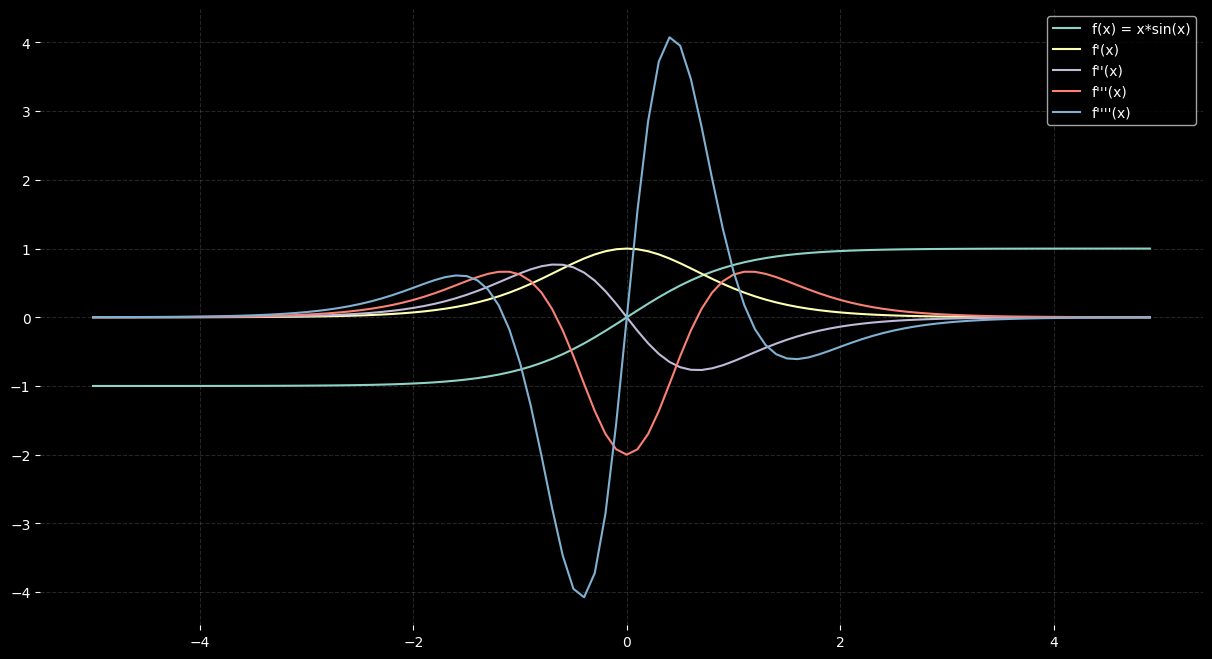

In [150]:
def func(x):
    return tanh(x)

def forward(func, vec):
    return [func(x) for x in vec]

x = [i / 10 for i in range(-50, 50)]

plt.figure(figsize=(15,8))
primals = forward(func, x)

# first derivative
f_prime = forward(deriv(func), x)
f_prime2 = forward(deriv(deriv(func)), x)
f_prime3 = forward(deriv(deriv(deriv(func))), x)
f_prime4 = forward(deriv(deriv(deriv(deriv(func)))), x)

plt.plot(x, primals, label='f(x) = x*sin(x)')
plt.plot(x, f_prime, label="f'(x)")
plt.plot(x, f_prime2, label="f''(x)")
plt.plot(x, f_prime3, label="f'''(x)")
plt.plot(x, f_prime4, label="f''''(x)")

plt.grid(True, linestyle="--", alpha=0.15)
plt.box(False)
plt.legend(loc='upper right')
plt.show()

In [151]:
from __future__ import annotations

import numpy as np
import numbers

from typing import Any, Hashable, Iterable

PyTreeTypes = list | dict | tuple | Any



In [152]:

class PyNode:
    def __init__(
        self, node_type: type, metadata: Hashable = None, child_tree: "PyNode" = None
    ):
        self.node_type = node_type
        self.metadata = metadata
        self.child_tree = child_tree

    def __repr__(self):
        s = f"({self.node_type.__name__ if self.node_type !='leaf' else 'leaf'}"
        if isinstance(self.metadata, np.ndarray) or self.metadata:
            s += f":{self.metadata.__class__.__name__}"
        if self.child_tree is not None:
            s += f",{self.child_tree}"
        return s + ")"

    @staticmethod
    def from_iter(pytree) -> tuple[Hashable, "PyNode"]:
        raise NotImplementedError("Not implemented")

    @staticmethod
    def to_iter() -> PyTreeTypes:
        raise NotImplementedError("Not implemented")

    def __eq__(self, other: PyNode) -> bool:
        if self.node_type != other.node_type:
            return False
        if self.child_tree != other.child_tree:
            return False
        return True


class ListNode(PyNode):
    @staticmethod
    def to_iter(lst):
        return None, lst

    @staticmethod
    def from_iter(_, iterable):
        return list(iterable)


class DictNode(PyNode):
    @staticmethod
    def from_iter(keys, vals):
        return dict(zip(keys, vals))

    @staticmethod
    def to_iter(dct):
        keys, values = [], []
        for key, value in sorted(dct.items()):
            keys.append(key)
            values.append(value)
        return keys, values


class TupleNode(PyNode):
    @staticmethod
    def from_iter(_, tup):
        return tuple(tup)

    @staticmethod
    def to_iter(tup):
        return None, tup


node_types: dict[Hashable, PyNode | None] = {
    list: ListNode,
    dict: DictNode,
    tuple: TupleNode,
}



In [153]:

def tree_flatten(x: Any) -> tuple[list[Any], PyNode]:
    def _flatten(x: Any) -> tuple[Iterable, PyNode]:
        data_type = type(x)
        node_type = node_types.get(data_type)
        if node_type is None:
            return [x], PyNode(node_type="leaf", metadata=x, child_tree=None)

        node_metadata, children = node_type.to_iter(x)

        children_flat, child_trees = [], []
        for node in children:
            flat, tree = _flatten(node)
            children_flat.extend(flat)
            child_trees.append(tree)

        subtree = PyNode(
            data_type,  # store the base type instead of the specific node type
            node_metadata,
            tuple(child_trees),
        )
        return children_flat, subtree

    flatten, pytree = _flatten(x)
    return flatten, pytree


def tree_unflatten(flattened_list: list, tree: PyNode) -> Any:
    def _unflatten(flattened_list: list, tree: PyNode) -> Any:
        if tree.node_type == "leaf":
            return next(flattened_list)

        children = []
        for child_tree in tree.child_tree:
            children.append(_unflatten(flattened_list, child_tree))

        node_type = node_types[tree.node_type]
        return node_type.from_iter(tree.metadata, children)

    return _unflatten(iter(flattened_list[:]), tree)


def flatten_fun(func, in_tree):
    store = {}

    def flat_fun(*args_flat):
        pytree_args = tree_unflatten(args_flat, in_tree)
        out = func(*pytree_args)
        out_flat, out_tree = tree_flatten(out)
        assert len(store) == 0, "Store already has a value!"
        store["tree"] = out_tree
        return out_flat

    return flat_fun, store


def display_tree(node: PyNode, indent: str = "") -> None:
    if node.node_type == "leaf":
        print(f"{indent}Leaf: {node.metadata}")
    else:
        node_type_name = node.node_type.__name__ if node.node_type != "leaf" else "leaf"
        print(f"{indent}{node_type_name}: {node.metadata}")
        for child in node.child_tree:
            display_tree(child, indent + "    ")


if __name__ == "__main__":
    x = [1, (2, {"a": 3, "b": 4}, 5), [6, 7]]
    flattened, tree = tree_flatten(x)
    print(x)
    print("\nTree structure:")
    display_tree(tree)
    print("\n")
    print("Flattened:", flattened)
    print("\n")

    reconstructed = tree_unflatten(flattened, tree)
    print("\nReconstructed:", reconstructed)
    assert x == reconstructed, "Reconstruction failed"
    print("Reconstruction successful!")


[1, (2, {'a': 3, 'b': 4}, 5), [6, 7]]

Tree structure:
list: None
    Leaf: 1
    tuple: None
        Leaf: 2
        dict: ['a', 'b']
            Leaf: 3
            Leaf: 4
        Leaf: 5
    list: None
        Leaf: 6
        Leaf: 7


Flattened: [1, 2, 3, 4, 5, 6, 7]



Reconstructed: [1, (2, {'a': 3, 'b': 4}, 5), [6, 7]]
Reconstruction successful!


In [154]:

# These functions create nested structures of ones or zeros that match the input structure

def nested_ones_like(item):
    """Create a nested structure of ones with the same shape as the input."""
    if isinstance(item, list):
        return [nested_ones_like(x) for x in item]
    if isinstance(item, tuple):
        return tuple(nested_ones_like(x) for x in item)
    if isinstance(item, dict):
        return {k: nested_ones_like(v) for k, v in item.items()}
    return 1.0 if isinstance(item, numbers.Number) else np.ones_like(item)


def nested_zero_like(item):
    """Create a nested structure of zeros with the same shape as the input."""
    if isinstance(item, list):
        return [nested_zero_like(x) for x in item]
    if isinstance(item, tuple):
        return tuple(nested_zero_like(x) for x in item)
    if isinstance(item, dict):
        return {k: nested_zero_like(v) for k, v in item.items()}
    return 0.0 if isinstance(item, numbers.Number) else np.zeros_like(item)


In [155]:

### Refinement of JVP
def jvp_flat(func, primals, tangents):
    with interpreter_context(JVPInterpreter) as iptr:
        tracers_in = [JVPBox(iptr, x, t) for x, t in zip(primals, tangents)]

        outs = func(*tracers_in)

        tracers_out = [full_raise(iptr, out) for out in outs]

        primals_out, tangents_out = [], []
        for t in tracers_out:
            primals_out.append(t.primal)
            tangents_out.append(t.tangent)

    return primals_out, tangents_out


def jvp(func, primals, tangents):
    # Flatten the primals and tangents into flat lists
    primals_flat, in_tree = tree_flatten(primals)
    tangents_flat, in_tree2 = tree_flatten(tangents)
    assert in_tree == in_tree2, "Input trees for primals and tangents must match"

    # Flatten the function f according to the input tree structure
    func_flat, out_tree = flatten_fun(func, in_tree)

    # forward pass
    primals_out_flat, tangents_out_flat = jvp_flat(
        func_flat, primals_flat, tangents_flat
    )

    assert len(out_tree) == 1, "out tree dict must have only one item"
    out_tree: PyNode = out_tree["tree"]

    primals_out = tree_unflatten(primals_out_flat, out_tree)
    tangents_out = tree_unflatten(tangents_out_flat, out_tree)

    return primals_out, tangents_out


def deriv(func, argnums=0):
    if isinstance(argnums, int):
        argnums = [argnums]

    def jvp_forward(*input_value):
        # pass tangent 1 for argnums and 0 for others
        tangents = tuple(
            nested_ones_like(x) if idx in argnums else nested_zero_like(x)
            for idx, x in enumerate(input_value)
        )

        _, gradient = jvp(func, input_value, tangents)

        return gradient

    return jvp_forward


def sigmoid(x):
    return 1 / (1 + exp(-x))


def tanh(x):
    return 2 * sigmoid(2 * x) - 1


def func(x, y):
    k = tanh(x) * 2.0 + y * y
    z0 = -y + k 
    z1 = y*k
    return {" lets": z0,"f*in":z1, "go!": [x, y]}



print("## pytree.py ##")
x = 3.14
y = 2.71
print(deriv(func, argnums=0)(x, y))


## pytree.py ##
{' lets': 0.01493120808257803, 'f*in': 0.040463573903786465, 'go!': [1.0, 0.0]}


In [156]:

### Refinement of VJP


def add_grads(grad1, grad2):
    if grad1 is None:
        return grad2
    return grad1 + grad2


def toposort(end_nodes):
    def _toposort(seen, node):
        result = []
        if node not in seen:
            seen.add(node)
            for p in node.parents:
                result.extend(_toposort(seen, p))
            result.append(node)
        return result

    outs = []
    seen = set()
    topo_sorted = []
    for end_node in end_nodes:
        topo_sorted.extend(_toposort(seen, end_node))

    for node in topo_sorted:
        if node.parents:
            outs.append(node)
    result = reversed(outs)
    return list(result)


def backward_pass(in_nodes, out_nodes, gradient):
    node_map = {out_node: g for g, out_node in zip(gradient, out_nodes)}

    topo_sorted = toposort(out_nodes)
    for node in topo_sorted:
        node_grad = node_map.pop(node)

        input_grads = node.vjp(node_grad)

        for input_grad, parent in zip(input_grads, node.parents):
            node_map[parent] = add_grads(node_map.get(parent), input_grad)

    return [node_map.get(node) for node in in_nodes]


def vjp_flat(func, args):
    with interpreter_context(VJPInterpreter) as iptr:
        box_in = [VJPBox(iptr, x, get_leaf_nodes()) for x in args]
        outs = func(*box_in)
        box_out = [full_raise(iptr, o) for o in outs]
        in_nodes = [box.node for box in box_in]
        out_nodes = [box.node for box in box_out]
        out_primals = [box.primal for box in box_out]

        def func_vjp(grad):
            return backward_pass(in_nodes, out_nodes, grad)

    return out_primals, func_vjp


def vjp(func, primals):
    # Flatten the primals and tangents into flat lists
    primals_flat, in_tree = tree_flatten(primals)

    # Flatten the function f according to the input tree structure
    func_flat, out_tree = flatten_fun(func, in_tree)

    # forward pass
    primals_out_flat, vjp_func = vjp_flat(
        func_flat,
        primals_flat,
    )

    assert len(out_tree) == 1, "out tree dict must have only one item"
    out_tree: PyNode = out_tree["tree"]

    primals_out = tree_unflatten(primals_out_flat, out_tree)

    return primals_out, vjp_func


def grad(func, argnums=0):
    if isinstance(argnums, int):
        argnums = [argnums]

    def vjp_func(*input_value):
        result, vjp_func = vjp(func, input_value)

        ones = nested_ones_like(result)
        flat, _ = tree_flatten(ones)
        grads = vjp_func(flat)
        _, in_tree = tree_flatten(input_value)
        grads = tree_unflatten(grads, in_tree)
        grads = tuple(g for idx, g in enumerate(grads) if idx in argnums)
        return grads[0] if len(argnums) == 1 else grads

    return vjp_func


def value_and_grad(func, argnums=0):
    if isinstance(argnums, int):
        argnums = [argnums]

    def vjp_forward(*input_value):
        result, vjp_func = vjp(func, input_value)

        # <hack>jax dont do this nasted ones funnny busniess
        # it just requires output to be scalar
        # but I you can pass one to all output nodes
        # which is effectively like result = sum(result) I dont have redution op
        # basically result.sum().backward() in pytorch
        ones = nested_ones_like(result)
        flat, _ = tree_flatten(ones)
        # </hack>

        # backward pass
        grads = vjp_func(flat)

        output, in_tree = tree_flatten(input_value)
        grads = tree_unflatten(grads, in_tree)

        grads = tuple(g for idx, g in enumerate(grads) if idx in argnums)

        return result, grads[0] if len(argnums) == 1 else grads

    return vjp_forward


Now you can do stuff like this, where you pass state dict and get grad for that state dict

In [157]:

def linear(state,inputs):
    weight,bias = state["weights"], state["bias"]
    total = 0
    for w, x in zip(weight, inputs):
        prod = w * x 
        total = total + prod 
    return total + bias

state = {"weights":[1,2,3], "bias": 1}
inputs  = [0.3, 0.5, 0.7]

print(grad(linear)(state,inputs))

{'bias': 1.0, 'weights': [0.3, 0.5, 0.7]}


In [158]:
value,grads = value_and_grad(linear)(state,inputs)
print(value)
print(grads)

4.3999999999999995
{'bias': 1.0, 'weights': [0.3, 0.5, 0.7]}


### Bounus 
Koding aventures are fun 

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from microjax import grad, exp

plt.style.use('dark_background')

def plot_functions(functions, speed=1, filename=None):
    x_values = np.linspace(-4.5, 4.5, 300)
    y_values = [func(x_values) for func in functions]

    fig, ax = plt.subplots(figsize=(12, 8))  # Increased figure size
    
    ax.plot(x_values, y_values[0], label="f(x) = tanh(x)")  # Plot primal function without animation
    lines = [ax.plot([], [], label=f"f{'′' * i}(x)")[0] for i in range(1, len(functions))]  # Start from 1 to skip f(x)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)  # Add faint grid background
    # ax.set_xticks([])  # Remove x-axis numbers
    # ax.set_yticks([])  # Remove y-axis numbers
    ax.legend(loc='upper right', frameon=True, facecolor='black', edgecolor='white')  # Add legend with visible background

    def init():
        for line in lines:
            line.set_data([], [])
        return lines

    def update(frame):
        frame = int(frame)
        if frame < len(x_values):
            x = x_values[:frame]
            for line, y in zip(lines, y_values[1:]):  # Start from y_values[1:] to skip f(x)
                line.set_data(x, y[:frame])
        else:
            frame = frame - len(x_values)
            x = x_values[frame:] if frame > 0 else x_values
            for line, y in zip(lines, y_values[1:]):  # Start from y_values[1:] to skip f(x)
                line.set_data(x, y[frame:] if frame > 0 else y)
        return lines

    ani = animation.FuncAnimation(fig, update, frames=2*len(x_values), init_func=init, blit=True, interval=20* speed)

    
    # Save the animation as a GIF
    if filename:
        ani.save(filename, writer='pillow', fps=30)
    # ani.
    plt.close(fig)  # Close the figure to prevent it from being displayed


def forward(func, vec):
    return [func(x) for x in vec]


x = [i / 100 for i in range(-500, 500)]

primals_fn = tanh
f_prime = grad(tanh)
f_double_prime = grad(grad(tanh))
f_triple_prime = grad(grad(grad(tanh)))
f_fourth_prime = grad(grad(grad(grad(tanh))))   
speed = 1
plot_functions([primals_fn, f_prime, f_double_prime, f_triple_prime, f_fourth_prime], speed=speed, filename='tanh_derivatives.gif')


![](tanh_derivatives.gif)